<a href="https://colab.research.google.com/github/Kanishk3813/Pathogen-Detection/blob/main/Pathogen_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!mkdir ~/.kaggle
!mv ./kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d kanishk3813/pathogen-dataset

100% 1.43G/1.43G [01:17<00:00, 22.5MB/s]
100% 1.43G/1.43G [01:17<00:00, 19.8MB/s]


In [ ]:
#Unzipping the file
import zipfile
zip_ref = zipfile.ZipFile('/content/pathogen-dataset.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import torch.nn as nn
import torch

from torchvision.models import resnet50, ResNet50_Weights
from torchvision import transforms

from PIL import Image
from torch.utils.data import Dataset, DataLoader

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from copy import deepcopy
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

import os

In [ ]:
def create_df(base_dir):
    dd = {"images": [], "labels": []}
    for i in os.listdir(base_dir):
        base = os.path.join(base_dir, i)
        index = 0
        for j in os.listdir(base):
            img = os.path.join(base, j)
            dd["images"] += [img]
            dd["labels"] += [i]
            index += 1
            if index >= 1000:
                break
    return pd.DataFrame(dd)

In [ ]:
df = create_df("/content/pathogen")

In [ ]:
le = LabelEncoder()
df["labels"] = le.fit_transform(df["labels"].values)

In [ ]:
EPOCHS = 20
BATCH = 128
LR = 0.1
STEP = 5
GAMMA = 0.5
OUT_CLASSES = df["labels"].nunique()
SIZE = 224

In [ ]:
class Pipe(Dataset):
    def __init__(self, data, transform):
        super(Pipe, self).__init__()
        self.data = data
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, x):
        img, label = self.data[x, 0], self.data[x, 1]
        img = self.transform(np.array(Image.open(img).convert("RGB")))
        return img, label

In [ ]:
train, validation = train_test_split(df.values, random_state=42, test_size=0.3)
test, val = train_test_split(validation, random_state=42, test_size=0.5)

In [ ]:
transform = transforms.Compose([transforms.ToPILImage(),
                               transforms.ToTensor(),
                               transforms.Resize((SIZE, SIZE)),
                               transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

In [ ]:
train_ds = Pipe(train, transform)
val_ds = Pipe(val, transform)

In [ ]:
train_dl = DataLoader(train_ds, batch_size=BATCH, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=BATCH, shuffle=False)

In [ ]:
resnet = resnet50(weights=ResNet50_Weights.IMAGENET1K_V2)
num_ftrs = resnet.fc.in_features
resnet.fc = nn.Linear(num_ftrs, OUT_CLASSES)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 170MB/s]


In [ ]:
class ResNetTune(nn.Module):
    def __init__(self, model):
        super(ResNetTune, self).__init__()
        self.model = model

    def forward(self, x):
        x = self.model(x)
        return nn.functional.softmax(x, dim=1)

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


In [ ]:
model = ResNetTune(resnet)
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=LR)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=STEP, gamma=GAMMA)

In [ ]:
best_model = deepcopy(model)
best_acc = 0

train_loss = []
train_acc = []
val_loss = []
val_acc = []

for i in range(1, EPOCHS+1):
    model.train()
    diff = 0
    total = 0
    acc = 0

    for data, target in train_dl:
        optimizer.zero_grad()
        if torch.cuda.is_available():
            data, target = data.cuda(), target.cuda()

        out = model(data)
        loss = criterion(out, target)
        diff += loss.item()
        total += out.size(0)
        acc += (out.argmax(1) == target).sum().item()
        loss.backward()
        optimizer.step()

    train_loss += [diff/total]
    train_acc += [acc/total]

    model.eval()
    diff = 0
    total = 0
    acc = 0
    with torch.no_grad():
        for data, target in val_dl:
            if torch.cuda.is_available():
                data, target = data.cuda(), target.cuda()

            out = model(data)
            loss = criterion(out, target)
            diff += loss.item()
            total += out.size(0)
            acc += (out.argmax(1) == target).sum().item()

    val_loss += [diff/total]
    val_acc += [acc/total]

    if val_acc[-1] > best_acc:
        best_acc = val_acc[-1]
        best_model = deepcopy(model)

    print("Epoch {} train loss {} acc {} val loss {} acc {}".format(i, train_loss[-1], train_acc[-1],
                                                                   val_loss[-1], val_acc[-1]))
    scheduler.step()

Epoch 1 train loss 0.011831273896353585 acc 0.5642857142857143 val loss 0.010279431502024332 acc 0.824
Epoch 2 train loss 0.008935869421277727 acc 0.8937142857142857 val loss 0.008177610079447428 acc 0.9413333333333334
Epoch 3 train loss 0.007890368921416147 acc 0.9491428571428572 val loss 0.007747482856114705 acc 0.9613333333333334
Epoch 4 train loss 0.007579583593777248 acc 0.9722857142857143 val loss 0.007619099140167236 acc 0.968
Epoch 5 train loss 0.007438319087028503 acc 0.9854285714285714 val loss 0.0075275669892628985 acc 0.9733333333333334
Epoch 6 train loss 0.0073777906724384855 acc 0.9891428571428571 val loss 0.007501381397247315 acc 0.9733333333333334
Epoch 7 train loss 0.007362945216042655 acc 0.9908571428571429 val loss 0.007488299449284872 acc 0.9746666666666667
Epoch 8 train loss 0.007344751000404358 acc 0.9917142857142857 val loss 0.007474232991536459 acc 0.976
Epoch 9 train loss 0.007334663799830846 acc 0.9934285714285714 val loss 0.007459842761357625 acc 0.9773333333

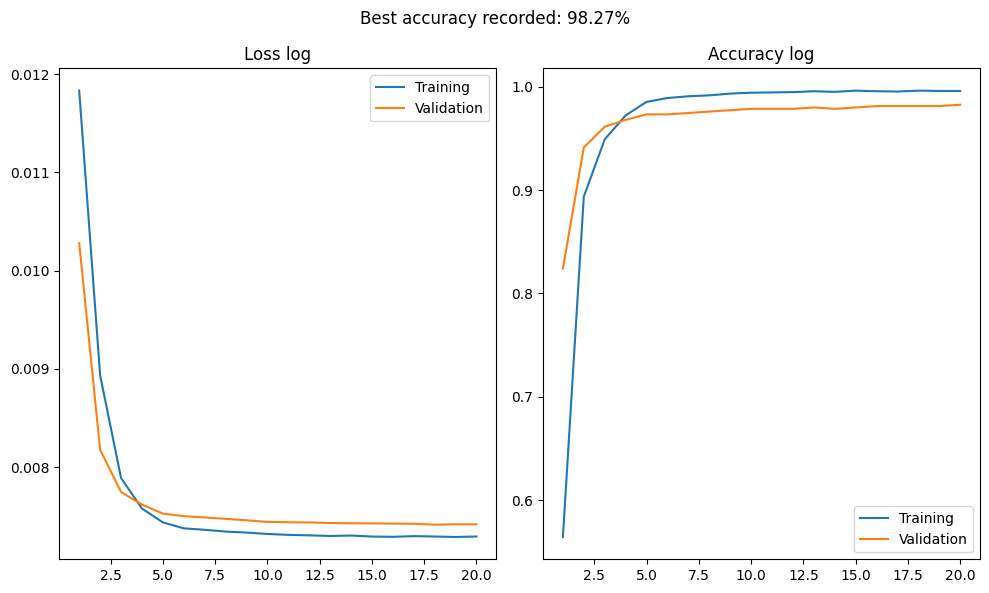

In [ ]:
epochs = list(range(1, EPOCHS+1))
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 6))

axes[0].plot(epochs, train_loss)
axes[0].plot(epochs, val_loss)
axes[0].legend(["Training", "Validation"])
axes[0].set_title("Loss log")

axes[1].plot(epochs, train_acc)
axes[1].plot(epochs, val_acc)
axes[1].legend(["Training", "Validation"])
axes[1].set_title("Accuracy log")
plt.suptitle("Best accuracy recorded: {}%".format(round(best_acc*100, 2)))
plt.tight_layout()
plt.show()


In [ ]:
def predict(img):
    image = Image.open(img).convert("RGB")
    image = transform(np.array(image))
    image = image.view(1, 3, SIZE, SIZE)
    best_model.eval()
    with torch.no_grad():
        if torch.cuda.is_available():
            image = image.cuda()

        out = best_model(image)
        return out.argmax(1).item()

In [ ]:
pred = []
truth = []
for i in range(test.shape[0]):
    pred += [predict(test[i, 0])]
    truth += [test[i, 1]]

              precision    recall  f1-score   support

           0       0.98      0.99      0.99       148
           1       0.99      0.97      0.98       153
           2       0.96      0.94      0.95       159
           3       0.95      0.97      0.96       142
           4       1.00      1.00      1.00       148

    accuracy                           0.97       750
   macro avg       0.97      0.98      0.97       750
weighted avg       0.97      0.97      0.97       750



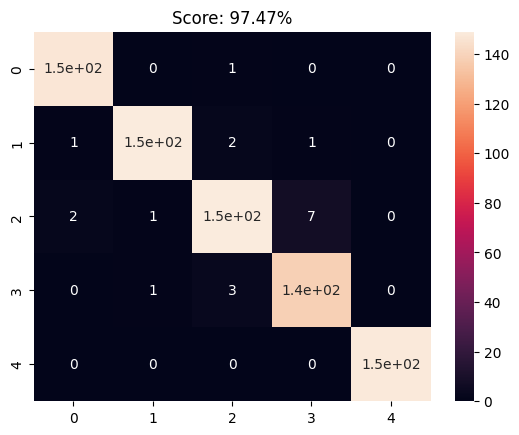

In [ ]:
score = accuracy_score(truth, pred)
report = classification_report(truth, pred)
print(report)
sns.heatmap(confusion_matrix(truth, pred), annot=True)
plt.title("Score: {}%".format(round(score*100, 2)))
plt.show()

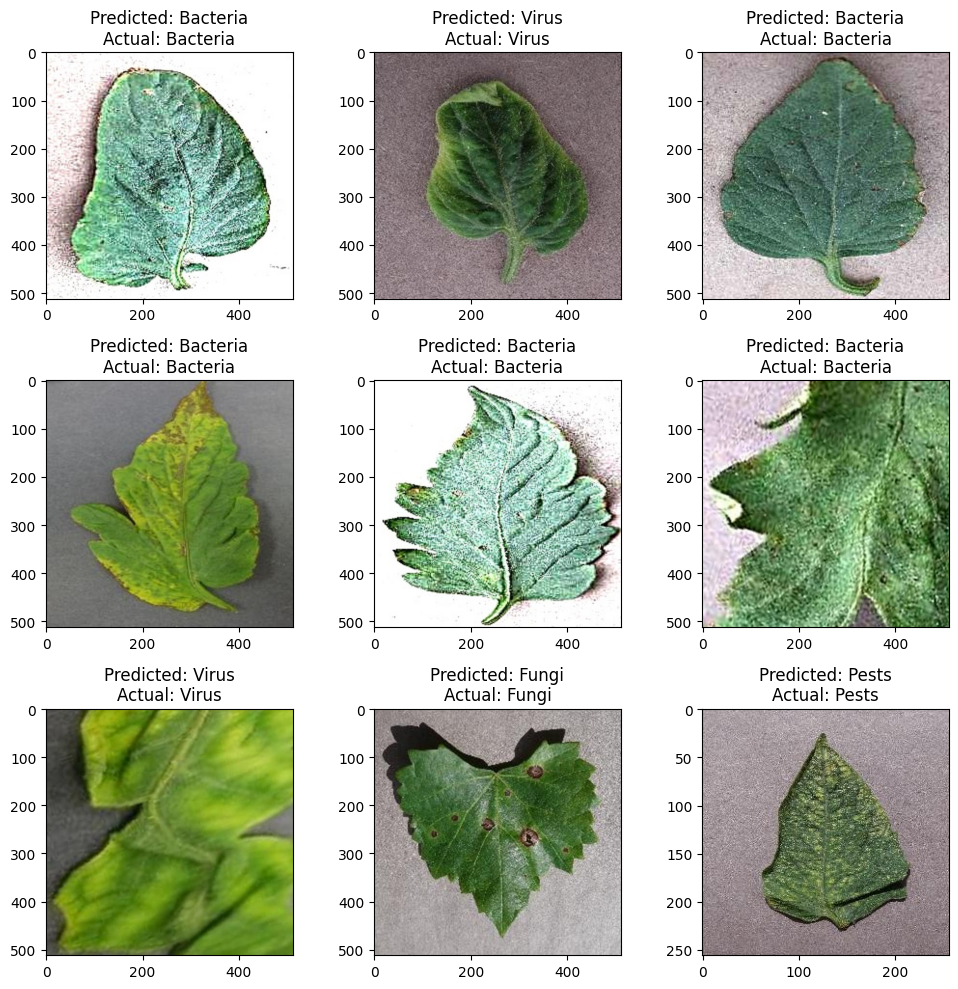

In [ ]:
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(10, 10))
index = 0
for i in range(3):
    for j in range(3):
        truth_label = le.inverse_transform([truth[index]])[0]
        pred_label = le.inverse_transform([pred[index]])[0]
        image = Image.open(test[index, 0]).convert("RGB")
        axes[i][j].imshow(np.array(image))
        axes[i][j].set_title("Predicted: {}\nActual: {}".format(truth_label, pred_label))
        index += 1

plt.tight_layout()
plt.show()

In [ ]:
import torch

torch.save(model, '/content/drive/MyDrive/pathogen_prediction_model2.pth')


In [ ]:
import torch
import torchvision.models as models

# Define example input tensor(s)
# In this example, we use a batch size of 1, 3 channels (RGB image), and size 224x224
example_input = torch.randn(1, 3, 224, 224)

# Export the model to ONNX format
onnx_path = "/content/drive/MyDrive/resnet50.onnx"
torch.onnx.export(model, example_input, onnx_path, export_params=True, opset_version=11)

print("Model successfully converted to ONNX format.")


Model successfully converted to ONNX format.
